In [22]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

from ocr.config import OCRConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config = OCRConfig(storage_root='/tmp/era5-vs-conus404')
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=False), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=False), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=False)

In [3]:
config.vector.building_geoparquet_uri

PosixUPath('/tmp/era5-vs-conus404/output/fire-risk/vector/qa/geoparquet/buildings.parquet')

In [125]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [32]:
building_file = gpd.read_parquet(
    's3://carbonplan-ocr/output/fire-risk/vector/staging/geoparquet/buildings.parquet'
)

In [33]:
census_tracts = gpd.read_parquet(
    's3://carbonplan-ocr/input/fire-risk/vector/aggregated_regions/tracts/tracts.parquet'
)

In [34]:
# intersects will duplicate buildings that straddle multiple census tracts. we could clean this up
# later by de-duplicating buildings
buildings_in_census_tracts = gpd.sjoin(building_file, census_tracts[['GEOID', 'geometry']])

In [68]:
def apply_kendall_tau(x, y):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant='b')
    return pd.Series({'tau': tau, 'p_value': p_value})

In [149]:
def apply_bias(x, y):
    bias = np.mean(x - y)
    return pd.Series({'bias': bias})

In [114]:
def apply_median(x, label):
    median = np.median(x)
    return pd.Series({f'median_{label}': median})

In [111]:
def apply_mean(x, label):
    mean = np.mean(x)
    return pd.Series({f'mean_{label}': mean})

In [96]:
def fraction_zeros(x, y):
    x_fract_zero = (x == 0).sum() / len(x)
    y_fract_zero = (y == 0).sum() / len(y)
    return pd.Series({'x_fract_zero': x_fract_zero, 'y_fract_zero': y_fract_zero})

In [73]:
county_tau = buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: apply_kendall_tau(g['wind_risk_2011'], g['USFS_RPS'])
)

/tmp/ipykernel_1577/1840318712.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant='b')
/tmp/ipykernel_1577/2731597064.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  county_tau = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: apply_kendall_tau(g['wind_risk_2011'], g['USFS_RPS']))


In [150]:
tract_performance_stats = census_tracts[['GEOID', 'geometry']].merge(county_tau, on='GEOID')

In [151]:
# add what fraction of the buildings have zero risk because those tracts should be removed since tau is NaN

In [152]:
new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: fraction_zeros(g['wind_risk_2011'], g['USFS_RPS'])
)
tract_performance_stats = tract_performance_stats.merge(new_gdf, on='GEOID')

/tmp/ipykernel_1577/2415457474.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: fraction_zeros(g['wind_risk_2011'], g['USFS_RPS']))


In [153]:
# add bias calculation
new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: apply_bias(g['wind_risk_2011'], g['USFS_RPS'])
)
tract_performance_stats = tract_performance_stats.merge(new_gdf, on='GEOID')

/tmp/ipykernel_1577/170702528.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: apply_bias(g['wind_risk_2011'], g['USFS_RPS']))


In [154]:
# add mean calculation for both x and y
for setup in ['wind_risk_2011', 'USFS_RPS']:
    new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(
        lambda g: apply_mean(g[setup], setup)
    )
    tract_performance_stats = tract_performance_stats.merge(new_gdf, on='GEOID')

/tmp/ipykernel_1577/880620066.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: apply_mean(g[setup], setup))
/tmp/ipykernel_1577/880620066.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: apply_mean(g[setup], setup))


In [155]:
# add mean calculation for both x and y
for setup in ['wind_risk_2011', 'USFS_RPS']:
    new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(
        lambda g: apply_median(g[setup], setup)
    )
    tract_performance_stats = tract_performance_stats.merge(new_gdf, on='GEOID')

/tmp/ipykernel_1577/1422591067.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: apply_median(g[setup], setup))
/tmp/ipykernel_1577/1422591067.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_gdf = buildings_in_census_tracts.groupby('GEOID').apply(lambda g: apply_median(g[setup], setup))


In [156]:
tract_performance_stats['normalized_bias'] = (
    tract_performance_stats['bias'] / tract_performance_stats['mean_USFS_RPS']
)

In [74]:
tract_performance_stats = census_tracts[['GEOID', 'geometry']].merge(county_tau, on='GEOID')

In [169]:
# filter out any places that are all zeros in either CP or USFS because they'll either make for NaN kendall tau or infinity in bias

In [173]:
tract_performance_stats = tract_performance_stats[~(tract_performance_stats['x_fract_zero'] == 1)]

In [174]:
tract_performance_stats = tract_performance_stats[~(tract_performance_stats['y_fract_zero'] == 1)]

In [195]:
variable_name_dict = {
    'tau': "Kendall's Tau of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'WRC median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {'tau': [-1, 1], 'bias': [-0.1, 0.1], 'normalized_bias': [-1, 1]}

cmaps = {'tau': 'PRGn', 'bias': 'RdBu', 'normalized_bias': 'RdBu'}

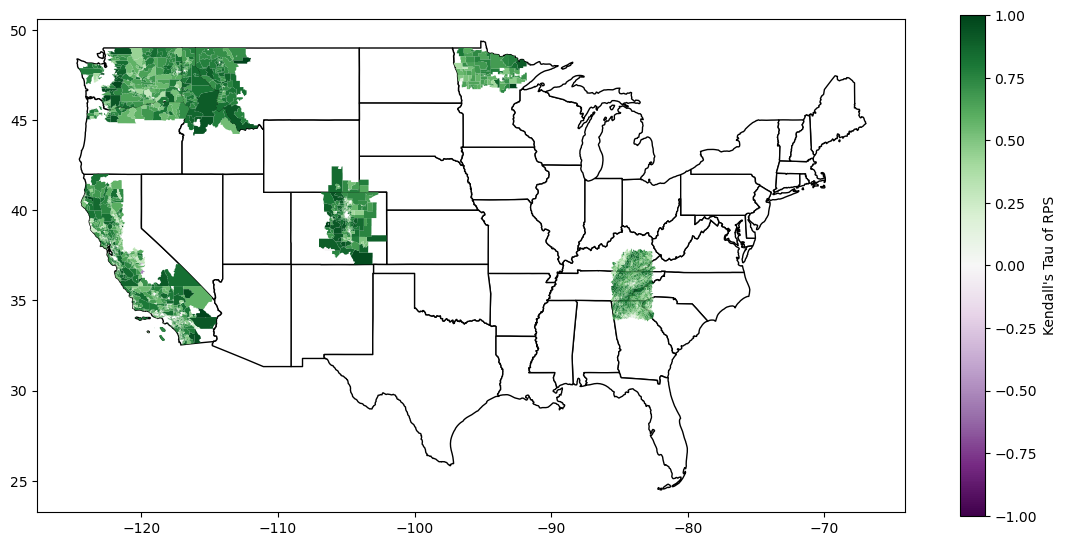

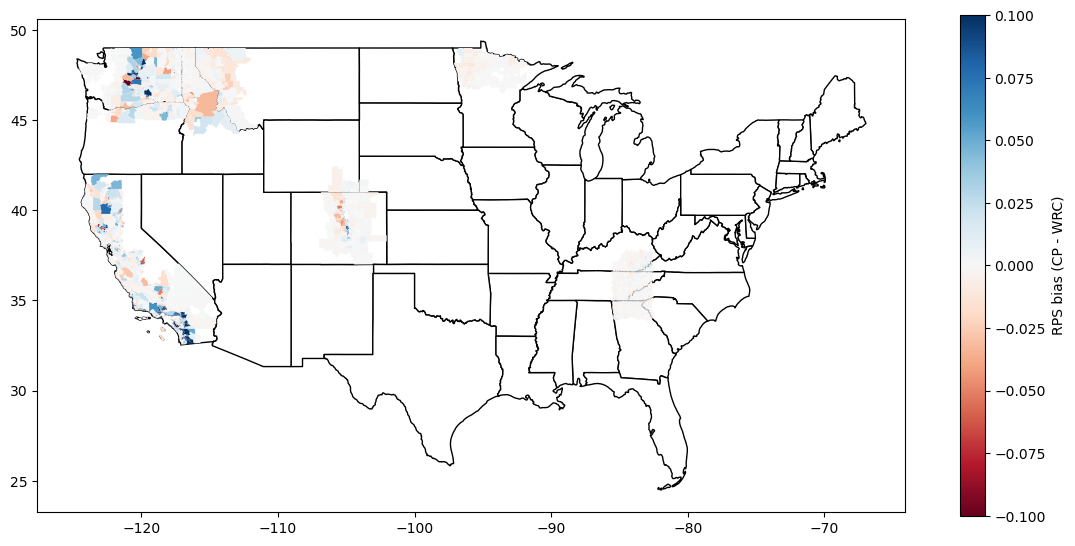

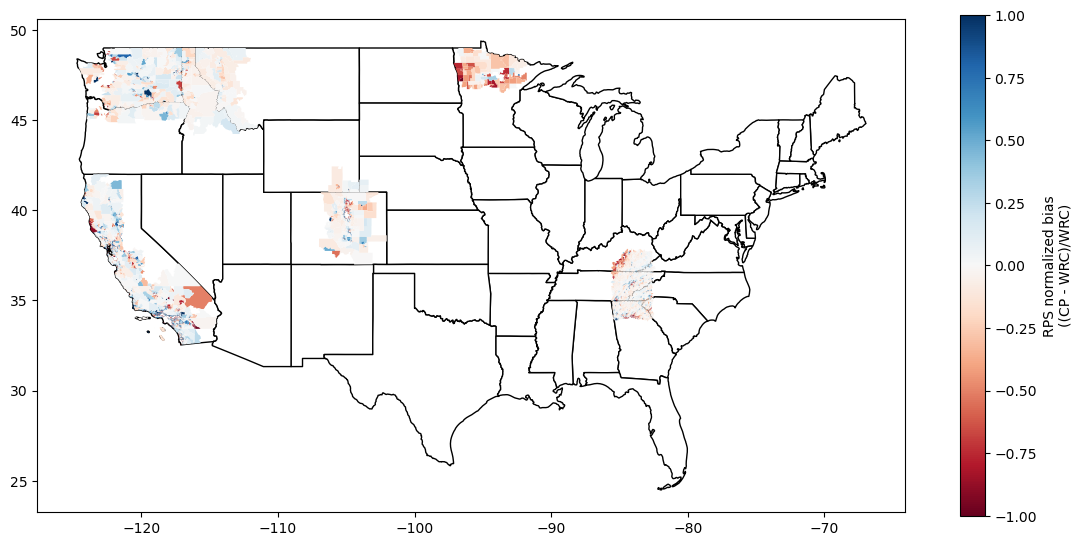

In [196]:
for variable in ['tau', 'bias', 'normalized_bias']:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

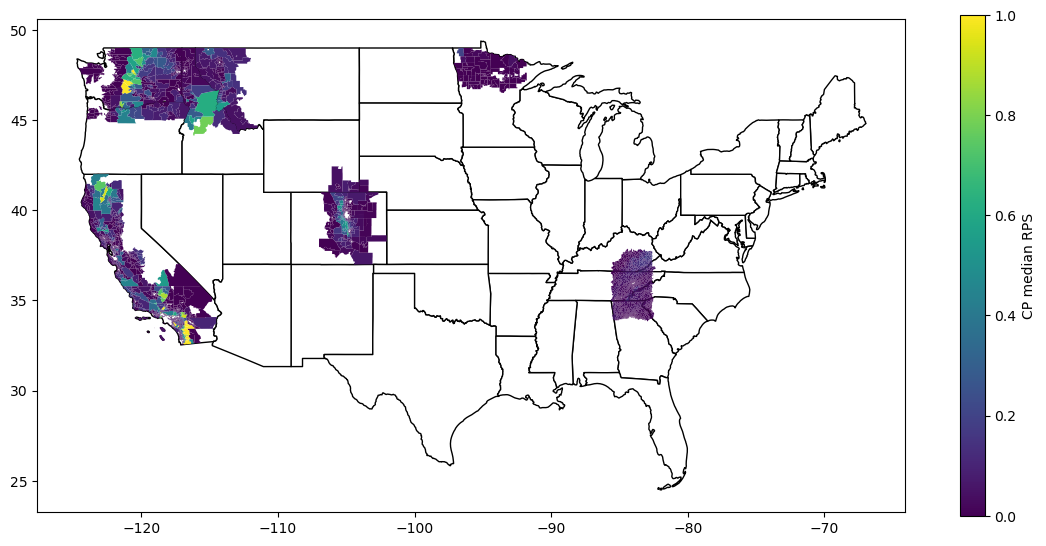

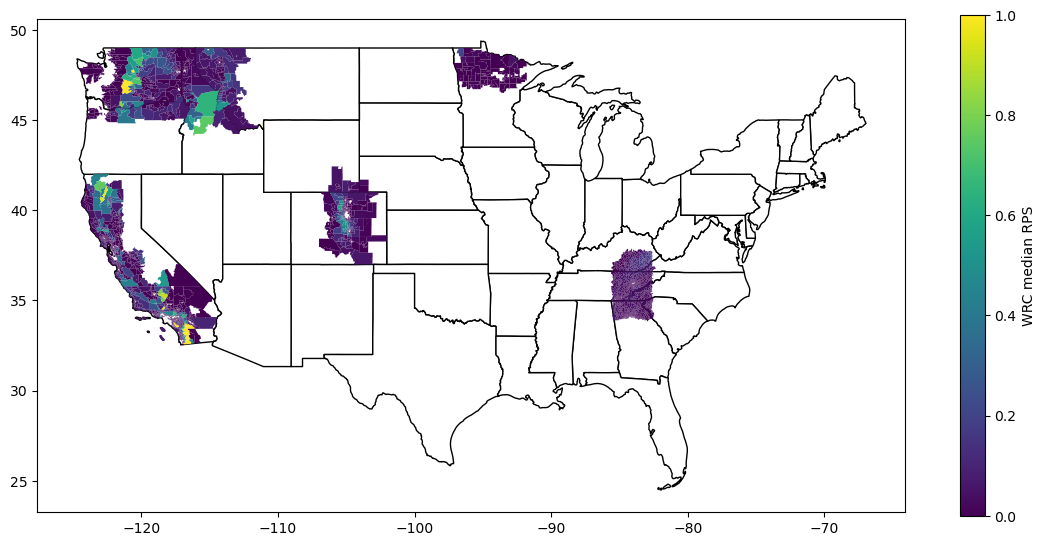

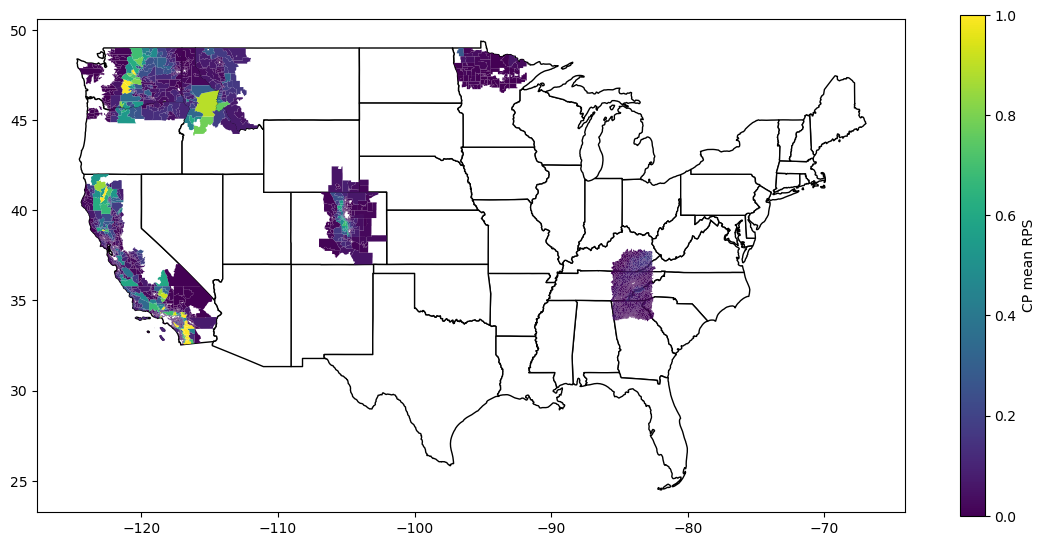

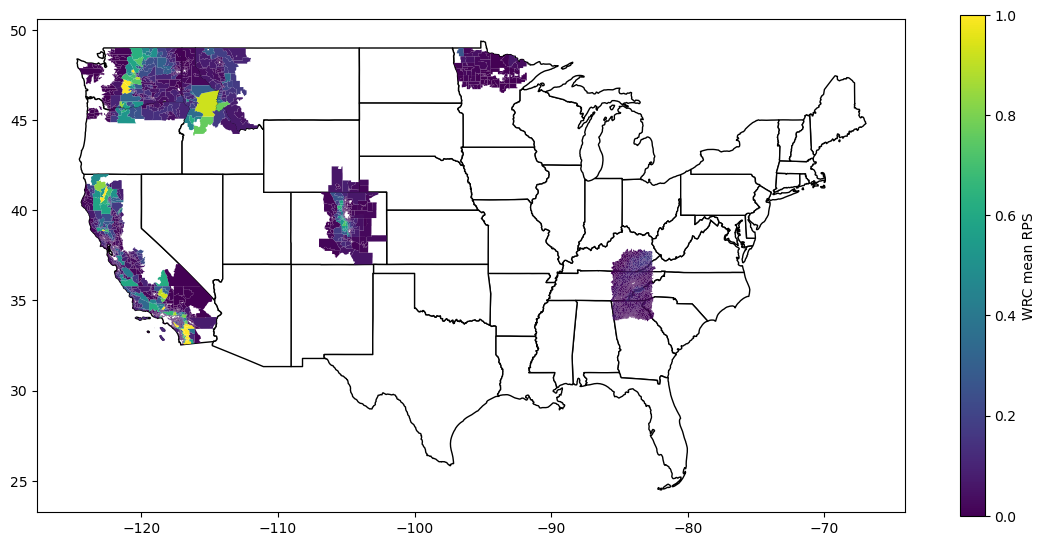

In [197]:
for variable in [
    'median_wind_risk_2011',
    'median_USFS_RPS',
    'mean_wind_risk_2011',
    'mean_USFS_RPS',
]:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=0,
        vmax=1,
        legend=True,
        cmap='viridis',
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

In [ ]:
# histogram of biases across entire domain

<Axes: ylabel='Frequency'>

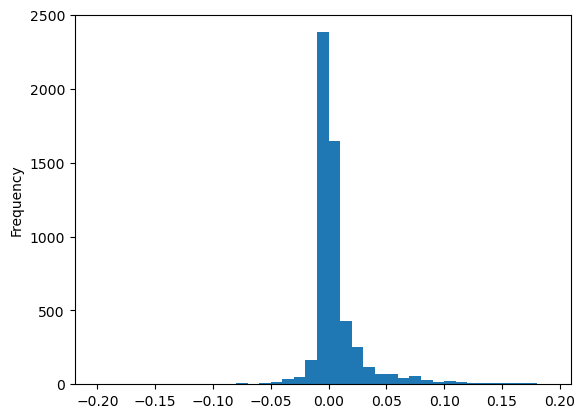

In [204]:
tract_performance_stats['bias'].plot(kind='hist', bins=np.arange(-0.2, 0.2, 0.01))

In [ ]:
# for sample census tracts (LA fires, Paradise, ...?) histograms of risk